In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from spikingjelly.spikingjelly.datasets.n_mnist import NMNIST
from spikingjelly.spikingjelly.datasets import play_frame
from spikingjelly.spikingjelly.activation_based import neuron, layer, learning
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display, clear_output
from time import sleep
from PIL import Image
import mnist
import numpy as np
from abc import ABCMeta, abstractmethod
from typing import cast
from utils.types import Tensor2D

In [2]:
## Deprecated code for mnist
# FILE_LIST = "MNIST/raw/train-images-idx3-ubyte MNIST/raw/train-labels-idx1-ubyte MNIST/raw/t10k-images-idx3-ubyte MNIST/raw/t10k-labels-idx1-ubyte".split()
# arrays:list[np.ndarray] = []

# for fname in FILE_LIST:
#     with open(fname,'rb') as f:
#         arrays.append(mnist.parse_idx(f))
# assert len(arrays) == 4
# train_imgs, train_labels, test_imgs, test_labels = arrays

In [3]:
w_min, w_max = 0., 1.
tau_pre, tau_post = 2., 2.
N_in, N_out = 2*34*34, 10
T = 64
batch_size = 2
lr = 0.01

adj_mat = torch.Tensor([
    [0, 1],
    [1, 0]
])

In [4]:
train_set = NMNIST("data/",train=True, data_type="frame", frames_number=T, split_by="number")
# test_set = NMNIST("data/",train=False, data_type="frame", frames_number=T, split_by="number")

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

The directory [data/frames_number_64_split_by_number] already exists.


In [5]:
play_frame(train_set[15000][0], save_gif_to="data_sample.gif")

Save frames to [data_sample.gif].


In [6]:
class STDPNet(nn.Module, metaclass=ABCMeta):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        
    def gen_block(self, in_features:int, out_features:int, **kwargs) -> nn.Sequential:
        return nn.Sequential(
            layer.Linear(in_features, out_features, **kwargs),
            neuron.LIFNode()
        )
    
    @abstractmethod
    def draw_weights(self) -> Tensor2D:
        pass
    
class Diehl2015(STDPNet):
    def __init__(self, in_features:int, hidden_features:int, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.in_features, self.hidden_features = in_features, hidden_features
        self.excitatory = layer.Linear(in_features, hidden_features, bias=False)
        self.inhibitory = layer.Linear(hidden_features, hidden_features, bias=False)
        self.inhibitory.weight.data = torch.eye(hidden_features) - torch.ones((hidden_features,hidden_features))
        self.lif_hidden = neuron.LIFNode()
        
        nn.init.trunc_normal_(self.excitatory.weight.data, 0.5, 0.25, 0, 1)
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        assert x[0].reshape(-1).shape[0] == self.in_features, f"{x[0].reshape(-1).shape[0]}, {self.in_features}"
        excitatory = self.lif_hidden(self.excitatory(x))
        inhibitory = self.lif_hidden(self.inhibitory(excitatory))
        return excitatory
    
    def draw_weights(self) -> Tensor2D:
        weight = self.excitatory.weight.data
        canvas = cast(Tensor2D, torch.zeros((2*34, 34*10)))
        for i_neuron in range(10):
            canvas[:, 34*i_neuron:34*(i_neuron+1)] = weight[i_neuron].reshape(34*2, 34)
        return canvas

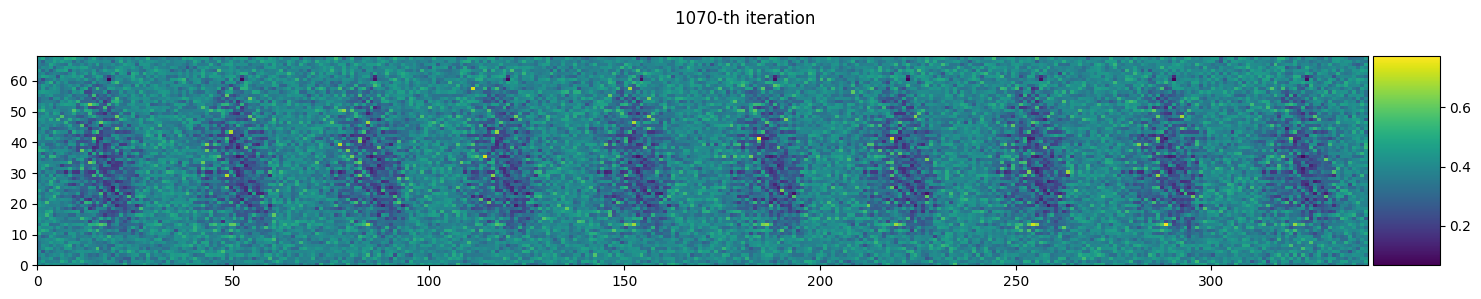

C:\Users\sizzf\AppData\Local\Temp\ipykernel_13384\2182594080.py:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame[:,::2,:] = torch.tensor(frames[:,t,0])
C:\Users\sizzf\AppData\Local\Temp\ipykernel_13384\2182594080.py:72: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frame[:,1::2,:] = torch.tensor(frames[:,t,1])


In [7]:
device = ["cpu", "cuda"][torch.cuda.is_available()]

def f_weight(x):
    return torch.clamp(x, -1, 1.)

torch.manual_seed(0)
# plt.style.use(['science'])

def f_pre(x, w_min, alpha=0.):
    return (x - w_min) ** alpha

def f_post(x, w_max, alpha=0.):
    return (w_max - x) ** alpha

def gen_block(in_features:int, out_features:int, **kwargs):
    return nn.Sequential(
        layer.Linear(in_features, out_features, **kwargs),
        neuron.LIFNode()
    )

# net = nn.Sequential(
#     gen_block(N_in, N_out)
# ).to(device)
# nn.init.trunc_normal_(net[0][0].weight.data, 0.4, 0.05, -1, 1)

net = Diehl2015(2*34*34, 100).to(device)

optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.)

# in_spike = (torch.rand([T, batch_size, N_in]) > 0.7).float()
learner = learning.STDPLearner(step_mode='s', synapse=net.excitatory, sn=net.lif_hidden, 
                                tau_pre=tau_pre, tau_post=tau_post,
                                f_pre=f_weight, f_post=f_weight)

out_spike = []
trace_pre = []
trace_post = []
# weight = []

# Make figure to plot
fig = plt.figure(figsize=(15, 3))
fig.suptitle(f"0-th iteration")
axes = []

# # Draw weights on the canvas
# canvas = torch.zeros((2*34, 34*10))
# weight = net[0][0].weight.cpu().detach()
# for i_neuron in range(10):
#     canvas[:, 34*i_neuron:34*(i_neuron+1)] = weight[i_neuron].reshape(34*2, 34)
    
# Subplot ops.
ax = fig.add_subplot(1,1,1) # generate new subplot.
pc = ax.pcolor(net.draw_weights()) # make sub ax for color-number map.
div = make_axes_locatable(ax) # get division of the subplot.
cax = div.append_axes("right", size="5%", pad=0.05) # new ax for color bar
fig.colorbar(pc, cax) # make colorbar.
fig.tight_layout() # fit plots to layout
d_handle = display(fig, display_id=True) # jupyter display output
assert d_handle is not None # display handle must be valid.
# clear_output(wait=True)

with torch.no_grad():
    frame = torch.zeros((batch_size, 2*34, 34), requires_grad=False, device=device) # *2 for ON, OFF events
    loader = iter(train_loader)
    for i, (frames, label) in enumerate(loader, start=1):
        for t in range(T):
            assert frames.shape == (batch_size,64,2,34,34), f"{frames.shape}"
            optimizer.zero_grad()
            # out_spike.append(net(in_spike[t]))
            frame.fill_(0)
            frame[:,::2,:] = torch.tensor(frames[:,t,0])
            frame[:,1::2,:] = torch.tensor(frames[:,t,1])
            net(frame.reshape(batch_size,-1))
            
            learner.step(on_grad=True)
            optimizer.step()
            net.excitatory.weight.data.clamp_(w_min, w_max)
            # weight.append(net[0].weight.data.clone())
            trace_pre.append(learner.trace_pre)
            trace_post.append(learner.trace_post)
        
        if i%10 == 0:
            fig.suptitle(f"{i}-th iteration")
            # weight = net[0][0].weight.cpu().detach()
            # for i_neuron in range(10):
            #     canvas[:,34*i_neuron:34*(i_neuron+1)] = weight[i_neuron].reshape(34*2, 34)
            pc = ax.pcolor(net.draw_weights())
            
            # ax.clear()
            # ax.set_title(f"{i}-th iteration")
            # ax.pcolor(net[0].weight.cpu().detach())
            fig.colorbar(pc, cax)
            d_handle.update(fig)
            # clear_output(wait=True)
        

out_spike = torch.stack(out_spike)   # [T, batch_size, N_out]
trace_pre = torch.stack(trace_pre)   # [T, batch_size, N_in]
trace_post = torch.stack(trace_post) # [T, batch_size, N_out]
weight = torch.stack(weight)         # [T, N_out, N_in]

In [ ]:
t = torch.arange(0, T).float()

# in_spike = in_spike[:, 0, 0] # No in_spike generation
out_spike = out_spike[:, 0, 0]
trace_pre = trace_pre[:, 0, 0]
trace_post = trace_post[:, 0, 0]
weight = weight[:, 0, 0]

cmap = plt.get_cmap('tab10')

# No in_spike generation
# plt.subplot(5, 1, 1)
# plt.eventplot((in_spike * t)[in_spike == 1], lineoffsets=0, colors=cmap(0))
# plt.xlim(-0.5, T + 0.5)
# plt.ylabel('$s[i]$', rotation=0, labelpad=10)
# plt.xticks([])
# plt.yticks([])

plt.subplot(5, 1, 2)
plt.plot(t, trace_pre, c=cmap(1))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$tr_{pre}$', rotation=0)
plt.yticks([trace_pre.min().item(), trace_pre.max().item()])
plt.xticks([])

plt.subplot(5, 1, 3)
plt.eventplot((out_spike * t)[out_spike == 1], lineoffsets=0, colors=cmap(2))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$s[j]$', rotation=0, labelpad=10)
plt.xticks([])
plt.yticks([])

plt.subplot(5, 1, 4)
plt.plot(t, trace_post, c=cmap(3))
plt.ylabel('$tr_{post}$', rotation=0)
plt.yticks([trace_post.min().item(), trace_post.max().item()])
plt.xlim(-0.5, T + 0.5)
plt.xticks([])

plt.subplot(5, 1, 5)
plt.plot(t, weight, c=cmap(4))
plt.xlim(-0.5, T + 0.5)
plt.ylabel('$w[i][j]$', rotation=0)
plt.yticks([weight.min().item(), weight.max().item()])
plt.xlabel('time-step')

plt.gcf().subplots_adjust(left=0.18)

plt.show()
plt.savefig('./stdp_trace.pdf')